In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pickle
import pandas as pd

import os
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf

In [3]:
dir_ = 'gz_grey_40/'
N = 58095

In [4]:
def load_image(d):
    
    img = Image.open(d)
    img.load()
    data = np.asarray(img, dtype='int32')
    
    return data

In [5]:
gzdata = np.zeros((N, 40, 40))

In [6]:
for i in range(N):
    d = dir_ + str(i+1) + '.jpg'
    gzdata[i] = load_image(d)

In [7]:
gzdata.max()
gzdata.shape

(58095, 40, 40)

## Data preprocessing

In [8]:
mydata = gzdata
print(np.shape(mydata))

(58095, 40, 40)


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test = train_test_split(mydata, train_size=0.7, shuffle=True, random_state=42)

In [11]:
X_train.max(), X_test.max()

(255.0, 255.0)

In [12]:
X_train = X_train/255

In [13]:
X_test = X_test/255

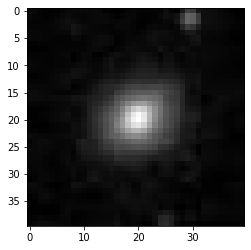

In [14]:
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [15]:
X_train = X_train.reshape((-1, 40, 40, 1))
X_test = X_test.reshape((-1, 40, 40, 1))

In [16]:
X_train.shape, X_test.shape

((40666, 40, 40, 1), (17429, 40, 40, 1))

## Model training 

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [18]:
discriminator = Sequential()

discriminator.add(Conv2D(6, kernel_size=(3,3), strides=(2,2), padding="same", activation='relu', input_shape=[40, 40, 1]))
discriminator.add(Conv2D(12, kernel_size=(3,3), strides=(2,2), padding="same", activation='relu'))
discriminator.add(Conv2D(24, kernel_size=(3,3), strides=(2,2), padding="same", activation='relu'))
discriminator.add(Flatten())
discriminator.add(Dense(300, activation='relu', input_shape=[600]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(10, activation='relu'))
discriminator.add(Dense(1, activation="sigmoid"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 6)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 12)        660       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 24)          2616      
_________________________________________________________________
flatten (Flatten)            (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [20]:
# size of the input noise array to generate fake images from
codings_size = 100

generator = Sequential()
generator.add(Dense(300,activation='relu', input_shape=[codings_size]))
generator.add(Dense(5*5*24, activation='relu'))
generator.add(Reshape([5, 5, 24]))
generator.add(Conv2DTranspose(filters=12, kernel_size=3, strides=(2,2), padding='same', activation='relu'))
generator.add(Conv2DTranspose(filters=6, kernel_size=3, strides=(2,2), padding='same', activation='relu'))
generator.add(Conv2DTranspose(filters=1, kernel_size=3, strides=(2,2), padding='same', activation='sigmoid'))

In [21]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_5 (Dense)              (None, 600)               180600    
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 24)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 12)        2604      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 6)         654       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 40, 40, 1)         55        
Total params: 214,213
Trainable params: 214,213
Non-trainable params: 0
________________________________________________

In [22]:
GAN = Sequential([generator, discriminator])

In [23]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [25]:
# Generator
GAN.layers[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_5 (Dense)              (None, 600)               180600    
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 24)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 12)        2604      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 6)         654       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 40, 40, 1)         55        
Total params: 214,213
Trainable params: 214,213
Non-trainable params: 0
________________________________________________

In [26]:
# Discriminator
GAN.layers[1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 6)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 12)        660       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 24)          2616      
_________________________________________________________________
flatten (Flatten)            (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

### Setting up Training Batches

In [27]:
import tensorflow as tf

In [28]:
batch_size = 512
my_data = mydata
my_data = my_data.reshape((-1, 40, 40, 1))
print(np.shape(my_data))

(58095, 40, 40, 1)


In [29]:
n_batch = int(58095 / batch_size)
print(n_batch)

113


In [30]:
X_batches = np.zeros((n_batch, batch_size, 40, 40, 1))

In [31]:
for i in range(n_batch):
    X_batches[i] = my_data[i*batch_size:(i+1)*batch_size]

In [32]:
epochs = 100

## Training Loop

In [33]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11182438161427657125
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17893009139374425685
physical_device_desc: "device: XLA_CPU device"
]


In [34]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [58]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    
    # For every batch in the dataset
    for X_batch in X_batches:
        
        i=i+1
        print(f"\tCurrently on batch number {i} of {n_batch}")
        
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
                
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, X_batch], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 1 of 113
	Currently on batch number 2 of 113
	Currently on batch number 3 of 113
	Currently on batch number 4 of 113
	Currently on batch number 5 of 113
	Currently on batch number 6 of 113
	Currently on batch number 7 of 113
	Currently on batch number 8 of 113
	Currently on batch number 9 of 113
	Currently on batch number 10 of 113
	Currently on batch number 11 of 113
	Currently on batch number 12 of 113
	Currently on batch number 13 of 113
	Currently on batch number 14 of 113
	Currently on batch number 15 of 113
	Currently on batch number 16 of 113
	Currently on batch number 17 of 113
	Currently on batch number 18 of 113
	Currently on batch number 19 of 113
	Currently on batch number 20 of 113
	Currently on batch number 21 of 113
	Currently on batch number 22 of 113
	Currently on batch number 23 of 113
	Currently on batch number 24 of 113
	Currently on batch number 25 of 113
	Currently on batch number 26 of 113
	Currently on batch number

KeyboardInterrupt: 

In [ ]:
noise = tf.random.normal(shape=[100, codings_size])
plt.imshow(noise)

In [ ]:
results = generator(noise)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, results.reshape((-1, 40, 40))):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()